Before SMOTE:
Total samples: 8025
High income: 2221
Low income: 5804

High income gender distribution:
sex
Male      1882
Female     339
Name: count, dtype: int64
Percentage female: 15.3%

After SMOTE:
Total samples: 11608
High income: 5804
Low income: 5804

Gender distribution in SYNTHETIC high income samples:
sex
Male      2591
Female     992
Name: count, dtype: int64
Percentage female: 27.7%


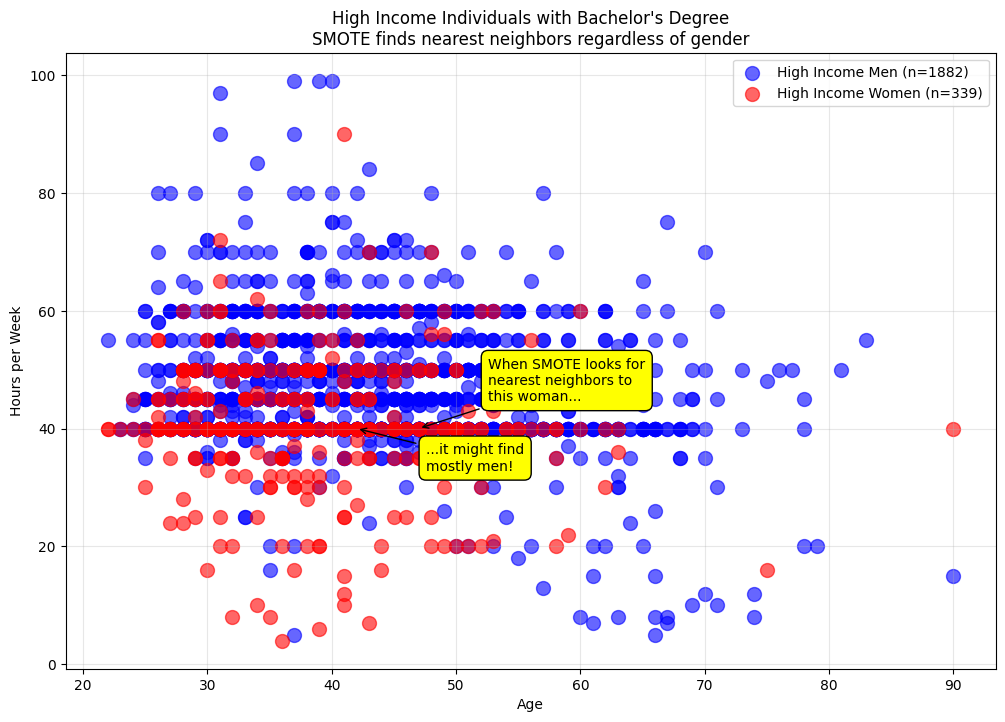

BIAS ANALYSIS - Original Data:
Disparate Impact: 0.403

BIAS ANALYSIS - After Standard SMOTE:
Disparate Impact: 0.698

Bias change: 73.0%

⚠️  Standard SMOTE often makes gender bias WORSE because it generates
synthetic samples based on proximity, ignoring protected attributes!


In [7]:
# Demonstrating SMOTE's Fairness Blindness
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from src.bias_detection.detector import BiasDetector

# Load our UCI Adult data
data = pd.read_csv('../data/processed/adult_with_labels.csv')

# Focus on a subset for clear visualization
# Let's look at people with Bachelor's degrees to see the pattern clearly
bachelors_data = data[data['education'] == 'Bachelors'].copy()

print("Before SMOTE:")
print(f"Total samples: {len(bachelors_data)}")
print(f"High income: {bachelors_data['high_income'].sum()}")
print(f"Low income: {len(bachelors_data) - bachelors_data['high_income'].sum()}")

# Check gender distribution in high income group
high_income_gender = bachelors_data[bachelors_data['high_income'] == 1]['sex'].value_counts()
print(f"\nHigh income gender distribution:")
print(high_income_gender)
print(f"Percentage female: {high_income_gender.get('Female', 0) / high_income_gender.sum() * 100:.1f}%")


# Cell 2: Apply Standard SMOTE
# Prepare data for SMOTE
X = bachelors_data.drop(columns=['income', 'high_income', 'is_female_high_income'])
y = bachelors_data['high_income']

# We need to encode categorical variables for SMOTE
from sklearn.preprocessing import LabelEncoder

# Store original categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns
encoders = {}

# Create a copy for SMOTE
X_encoded = X.copy()

# Encode categorical variables
for col in categorical_columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col])
    encoders[col] = le

# Apply SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

# Decode back to original values for analysis
X_resampled_decoded = X_resampled.copy()
for col, le in encoders.items():
    X_resampled_decoded[col] = le.inverse_transform(X_resampled[col].astype(int))

print(f"\nAfter SMOTE:")
print(f"Total samples: {len(X_resampled_decoded)}")
print(f"High income: {y_resampled.sum()}")
print(f"Low income: {len(y_resampled) - y_resampled.sum()}")

# Cell 3: The Critical Problem - Gender Bias Gets Worse!
# Check gender distribution in the synthetic high income samples

# Identify which samples are synthetic (new ones added by SMOTE)
original_size = len(X)
synthetic_mask = np.zeros(len(X_resampled), dtype=bool)
synthetic_mask[original_size:] = True  # Everything after original size is synthetic

# Look at synthetic high income samples
synthetic_high_income = X_resampled_decoded[synthetic_mask & (y_resampled == 1)]
synthetic_gender_dist = synthetic_high_income['sex'].value_counts()

print("\nGender distribution in SYNTHETIC high income samples:")
print(synthetic_gender_dist)
if 'Female' in synthetic_gender_dist.index:
    female_pct = synthetic_gender_dist['Female'] / synthetic_gender_dist.sum() * 100
    print(f"Percentage female: {female_pct:.1f}%")
else:
    print("Percentage female: 0.0%")

# Cell 4: Visualizing Why This Happens
import matplotlib.pyplot as plt

# Let's visualize why SMOTE creates mostly male samples
# We'll use age and hours-per-week as our features for visualization

high_income_data = bachelors_data[bachelors_data['high_income'] == 1]
male_high_income = high_income_data[high_income_data['sex'] == 'Male']
female_high_income = high_income_data[high_income_data['sex'] == 'Female']

plt.figure(figsize=(12, 8))

# Plot male high income (majority within minority class)
plt.scatter(male_high_income['age'], male_high_income['hours-per-week'], 
           c='blue', s=100, alpha=0.6, label=f'High Income Men (n={len(male_high_income)})')

# Plot female high income (minority within minority class)
plt.scatter(female_high_income['age'], female_high_income['hours-per-week'], 
           c='red', s=100, alpha=0.6, label=f'High Income Women (n={len(female_high_income)})')

plt.xlabel('Age')
plt.ylabel('Hours per Week')
plt.title('High Income Individuals with Bachelor\'s Degree\n' + 
          'SMOTE finds nearest neighbors regardless of gender')
plt.legend()
plt.grid(True, alpha=0.3)

# Add annotations to explain the problem
plt.annotate('When SMOTE looks for\nnearest neighbors to\nthis woman...', 
             xy=(female_high_income.iloc[0]['age'], female_high_income.iloc[0]['hours-per-week']),
             xytext=(50, 20), textcoords='offset points',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow'),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.annotate('...it might find\nmostly men!', 
             xy=(male_high_income.iloc[0]['age'], male_high_income.iloc[0]['hours-per-week']),
             xytext=(50, -30), textcoords='offset points',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow'),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.show()

# Cell 5: Quantifying the Bias Problem
# Let's measure bias before and after standard SMOTE

detector = BiasDetector(verbose=False)

# Original bias
print("BIAS ANALYSIS - Original Data:")
original_metrics = detector.detect_bias(X, y, protected_attribute='sex', positive_label=1)
print(f"Disparate Impact: {original_metrics.disparate_impact:.3f}")

# After SMOTE bias
print("\nBIAS ANALYSIS - After Standard SMOTE:")
smote_metrics = detector.detect_bias(X_resampled_decoded, y_resampled, 
                                    protected_attribute='sex', positive_label=1)
print(f"Disparate Impact: {smote_metrics.disparate_impact:.3f}")

print(f"\nBias change: {((smote_metrics.disparate_impact - original_metrics.disparate_impact) / original_metrics.disparate_impact * 100):.1f}%")
print("\n⚠️  Standard SMOTE often makes gender bias WORSE because it generates")
print("synthetic samples based on proximity, ignoring protected attributes!")



